# NeedleMaster Dataset Example

Predict the needle position and orientation from an image

## Imports 
* pytorch_datasets for Dataset class, DataLoader
* tdqm for interactive loading bars 
* numpy for math 
* torch for deep learning library
* torchvision for deep learning vision library 
* multiprocessing to run on multiple cpus (if applicable)
* random to select random trials/frames in _get__item_, and to make random datasplits
* matplotlib for displaying image frames
* pdb (debugging)

In [1]:
import sys
sys.path.insert(0, '/home/molly/workspace/Utils/pytorch_datasets/')

import random 
import numpy as np
from tqdm import tqdm as tdqm
import multiprocessing
import matplotlib.pyplot as plt
from matplotlib import patches
from pdb import set_trace as woah

import torch
import torchvision
import pytorch_datasets
import torch.nn.functional as F

Code to set up the environment. Choose if the deep learning will run on the CPU or GPU. Initialize the torch random seed, and if using a GPU the GPU random seed. 

In [2]:
torch.manual_seed(random.randint(1, 10000))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if(DEVICE == "cuda:0"):
    torch.cuda.manual_seed(random.randint(1, 10000))
    # Disable nondeterministic ops (not sure if critical but better safe than sorry)
    torch.backends.cudnn.enabled = False  

## Introduction
This notebook is an example for using the Pytorch Datasets wrapper to write a data loader for the NeedleMaster dataset. 

* __NeedleMaster__ is an Android game developped by Chris Paxton (https://github.com/cpaxton/needle_master_tools.) Images from recorded demonstrations were rendered to create a toy dataset with images, needle poses, and user actions. This dataset is currently on a local directory. For information contact molly@jhu.edu. 


## Loading Data 

In [3]:
ENVIRONMENT = '17'

nm = pytorch_datasets.NeedleFrames('/home/molly/workspace/Surgical_Automation/experiments/needle_master_tools/', \
                                   environment=ENVIRONMENT)

The attribute '_getitem_' can be used to load individual images and needle poses. If discrete=False, The needle position is x/screen_width, y/screen_width, and theta/2_pi. Otherwise the needle position is which 1/10 region the x, y, z is in.

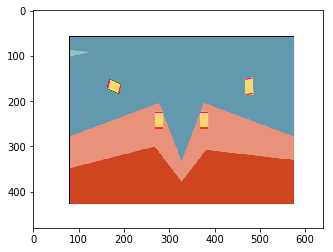

needle pose: [ 0.08312117  0.09591495  0.49150738]


In [4]:
% matplotlib inline
sample = nm.__getitem__()#idx=100, frame_idx=10)

plt.imshow(sample['image'])
#plt.scatter(sample['needle'][0]*500 + 80, sample['needle'][1]*370 + 60, c='r')
plt.show()

print('needle pose: ' + str(sample['needle']))

### Compute the mean and std of the image channels
Use this data to normalize later. (Note, make sure that ENVIRONMENT is the env you want to use later, otherwise the means/stds won't be useful)

In [5]:
#Create datasets
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.CenterCrop((172,172)),
    torchvision.transforms.ToTensor(),
       
])

root = '/home/molly/workspace/Surgical_Automation/experiments/needle_master_tools/'
dataset = pytorch_datasets.NeedleFrames(root, transforms=transforms, environment=ENVIRONMENT)
# Create dataloaders
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True,  batch_size=100,  num_workers=multiprocessing.cpu_count())

In [6]:
means = []; varz = []; batch_size = []

for dat in dataloader: 
    mean = [dat['image'][:,0,:,:].mean(), dat['image'][:,1,:,:].mean(), dat['image'][:,2,:,:].mean()]
    var  = [dat['image'][:,0,:,:].std()**2,  dat['image'][:,1,:,:].std()**2,  dat['image'][:,2,:,:].std()**2]
    
    means.append(mean); varz.append(var); batch_size.append(dat['image'].shape[0])

In [7]:
data_mean = np.mean(np.array(means), axis=0)
data_std  = np.sqrt(np.mean(np.array(varz), axis=0))
print(data_mean)
print(data_std)

[ 0.61992002  0.50780451  0.48664364]
[ 0.23403575  0.1546659   0.23976287]


## Model 
A pretrained resnet18 model is used with a final fully connected layer. The FC layer is used to regress the pose of the needle.

In [8]:
class resnet18(torch.nn.Module):
    """ Example Model. ResNet18 with a regression layer on top. """
    def __init__(self, side_len, n_classes, num_labels, mode='regress'):
        super(resnet18, self).__init__()
        self.base_model = torch.nn.Sequential(*list(torchvision.models.resnet18(pretrained=True).children())[:-1])
        base_model_fc_size = list(self.base_model.parameters())[-1].size(0)
        if(mode == 'regress'):
            self.fc = torch.nn.Linear(base_model_fc_size, num_labels)
        elif(mode == 'classify'):
            self.fc = torch.nn.Linear(base_model_fc_size, n_classes)
        self.sm = torch.nn.Softmax()
        
    def forward(self, images):
        im_features = self.base_model(images)
        preds = self.fc(im_features.squeeze())
        return preds

In [9]:
class cnn3(torch.nn.Module):
    """ small network trained from scratch"""
    def __init__(self, n_classes, num_labels, mode='regress'):
        super(cnn3, self).__init__()
        # convolutional layers 
        self.conv1 = torch.nn.Conv2d(3,   5, 5, stride=2)
        self.conv2 = torch.nn.Conv2d(5,  10, 5, stride=2)
        self.conv3 = torch.nn.Conv2d(10, 20, 5, stride=2)
        self.relu  = torch.nn.ReLU()
        
        self.mode = mode
        
        if(mode == 'classify'):
            self.fc1  = torch.nn.Linear(6480, n_classes)
        elif(mode == 'regress'):
            self.fc1  = torch.nn.Linear(6480, num_labels)
            
        self.sm  = torch.nn.Softmax()
        
    def forward(self, images):
        im_size = images.shape
        h1 = self.relu(self.conv1(images))
        h2 = self.relu(self.conv2(h1))
        h3 = self.relu(self.conv3(h2))
        
        preds = self.fc1(h3.view(im_size[0], -1).squeeze())
        return preds

In [10]:
class cnn5(torch.nn.Module):
    """ small network trained from scratch"""
    def __init__(self, n_classes, num_labels, mode='regress'):
        super(cnn5, self).__init__()
        # convolutional layers 
        self.conv1 = torch.nn.Conv2d(3,   5, 5, padding=True)
        self.conv2 = torch.nn.Conv2d(5,  10, 5, padding=True)
        self.conv3 = torch.nn.Conv2d(10, 20, 5, padding=True)
        self.conv4 = torch.nn.Conv2d(20, 30, 5, padding=True)
        self.conv5 = torch.nn.Conv2d(30, 40, 5, padding=True)
        self.pool  = torch.nn.AvgPool2d(2, stride=2)
        #self.relu  = torch.nn.ReLU()
        
        self.mode = mode
        
        if(mode == 'classify'):
            self.fc1  = torch.nn.Linear(360, n_classes)
        elif(mode == 'regress'):
            self.fc1  = torch.nn.Linear(360, num_labels)
            
        #self.fc2 = torch.nn.Linear(100,  num_labels)
        self.sm   = torch.nn.Softmax()
        
        
    def forward(self, images):
        im_size = images.size()

        h1 = F.relu(self.pool(self.conv1(images)))
        h2 = F.relu(self.pool(self.conv2(h1)))
        h3 = F.relu(self.pool(self.conv3(h2)))
        h4 = F.relu(self.pool(self.conv4(h3)))
        h5 = F.relu(self.pool(self.conv5(h4)))
        
        if(self.mode == 'classify'):
            preds = self.fc1(h5.view(im_size[0] , -1).squeeze())
            
        elif(self.mode == 'regress'):
            preds = self.fc1(h5.view(im_size[0], -1).squeeze()) #OPT: add softmax 
            #preds = self.fc2(self.fc1(h5.view(im_size[0], n_classes, -1).squeeze()))
            
        return preds

## Training Epoch
Code to do one epoch of training

In [11]:
def epoch(train_mode, description, model, dataloader, optimizer=None, loss_func=None):
    """ Train, validation, or test epoch """
    # Create dataset iterator
    #iterator = tqdm(dataloader, ncols=115, desc=description)

    # Turn off batch norm, etc. during testing/validation
    model = model.train(train_mode)

    # Data to print
    running_losses, running_predict, running_x, running_y, running_w = [], [], [], [], []

    # Loop over all data
    with torch.set_grad_enabled(train_mode):
        for data in dataloader:
            outputs = model(data['image'].to(DEVICE))# Forward pass
            
            if train_mode:
                optimizer.zero_grad() # Zero out gradients
                ## Regress
                if(model.mode == 'regress'):
                    loss = loss_func(outputs.double(), data['needle'].double().to(DEVICE))#
                
                ## Classify
                elif(model.mode == 'classify'):
                    loss = loss_func(outputs.double(), torch.cuda.LongTensor(data['needle'][:,0].to(DEVICE))) # 
                
                running_losses.append(loss.detach().item())
                loss.backward()
                optimizer.step()
                
            # Update labels and predictions
            if(model.mode == 'regress'):
                prediction = outputs.cpu().detach().numpy()
                error_x     = np.mean(abs(data["needle"].numpy()[:,0] - prediction[:,0]))
                error_y     = np.mean(abs(data["needle"].numpy()[:,1] - prediction[:,1]))
                error_w     = np.mean(abs(data["needle"].numpy()[:,2] - prediction[:,2]))
                
            elif(model.mode == 'classify'):
                prediction = np.argmax(outputs.cpu().detach().numpy(), axis=1)
                error_x     = np.mean(abs(data["needle"].numpy()[:,0] - prediction))
                error_y     = -0.1 # NOTE: we're only predicting x so no y error
                error_w     = -0.1 # NOTE: we're only predicting x so no z error
                
            running_predict.extend(prediction)

            # Update accuracy
            
            running_x.append(error_x); running_y.append(error_y); running_w.append(error_w)
                          
#             info_to_show = {'Error x': "{:.4f}".format(error_x)}
            
#             if train_mode:
#                 info_to_show['Loss'] = "{:.5f}".format(np.mean(running_losses))
#             iterator.set_postfix(info_to_show)
    
    return running_losses, running_predict, running_x, running_y, running_w, model

## main 

In [12]:
MODE = 'classify'

# Create image tranforms
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.CenterCrop((172,172)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=data_mean, std=data_std),
    
])

# Create datasets
root = '/home/molly/workspace/Surgical_Automation/experiments/needle_master_tools/'
dataset_train = pytorch_datasets.NeedleFrames(root, environment=ENVIRONMENT, transforms=transforms_train, \
                                              discrete=MODE=='classify')

# Create dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, shuffle=True,  batch_size=256,  \
                                               num_workers=multiprocessing.cpu_count())

# Create Model
regress_dim = 3
n_classes   = 10
model       = cnn3(n_classes, regress_dim, mode=MODE).to(DEVICE)

# Create loss function and optimizer
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.0001)

if(MODE=='regress'):
    loss_func = torch.nn.MSELoss().to(DEVICE)
elif(MODE=='classify'):
    loss_func = torch.nn.CrossEntropyLoss().to(DEVICE)

# Train + Val
Loss, Error_x, Error_y, Error_w = [], [], [], []
num_epochs = 5
for epoch_idx in range(num_epochs):
    loss, pred, e_x, e_y, e_w, model = epoch(True, "Training", model, dataloader_train, optimizer, loss_func)
    Loss.extend(loss); Error_x.extend(e_x); Error_y.extend(e_y); Error_w.extend(e_w)
    #epoch(False, "Validating", model, dataloader_val)
    print("Epoch: " + str(epoch_idx) + "    Loss: "+ "%1.2f" % np.mean(loss) + \
          "\t Error_x: "+ "%1.2f" % np.mean(e_x) , end='\r')
# Test
#epoch(False, "Testing", model, dataloader_test)

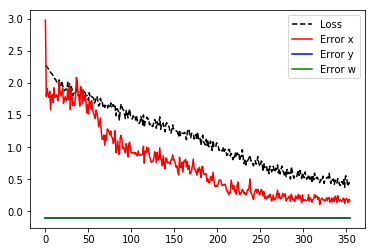

In [13]:
fig = plt.figure()#figsize=(10,5))
plt.plot(Loss, 'k--', label='Loss')
plt.plot(Error_x, c='r', label='Error x')
plt.plot(Error_y, c='b', label='Error y')
plt.plot(Error_w, c='g', label='Error w')
plt.legend()
plt.show()

## Evaluating the model

In [28]:
# get the stats of the test environment
test_environment = '14'

root = '/home/molly/workspace/Surgical_Automation/experiments/needle_master_tools/'
test_dataset = pytorch_datasets.NeedleFrames(root, environment=test_environment,\
                                             discrete=MODE=='classify')
# Create dataloaders
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True,  batch_size=100, \
                                              num_workers=multiprocessing.cpu_count())

In [29]:
test_means = []; test_varz = []; test_batch_size = []

for dat in test_dataloader: 
    mean = [dat['image'][:,0,:,:].mean(), dat['image'][:,1,:,:].mean(), dat['image'][:,2,:,:].mean()]
    var  = [dat['image'][:,0,:,:].std()**2,  dat['image'][:,1,:,:].std()**2,  dat['image'][:,2,:,:].std()**2]
    
    test_means.append(mean); test_varz.append(var); test_batch_size.append(dat['image'].shape[0])

RuntimeError: Can only calculate the mean of floating types. Got Byte instead.

In [ ]:
test_data_mean = np.mean(np.array(test_means), axis=0)
test_data_std  = np.sqrt(np.mean(np.array(test_varz), axis=0))
print(test_data_mean)
print(test_data_std)

In [14]:
#Create datasets
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.CenterCrop((172,172)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=test_data_mean, std=test_data_std),
       
])

root = '/home/molly/workspace/Surgical_Automation/experiments/needle_master_tools/'
test_dataset = pytorch_datasets.NeedleFrames(root, transforms=test_transforms, environment=test_environment,\
                                             discrete=MODE=='classify')
# Create dataloaders
test_dataloader = torch.utils.data.DataLoader(dataset, shuffle=True,  batch_size=100, \
                                              num_workers=multiprocessing.cpu_count())

### Visualize Predictions

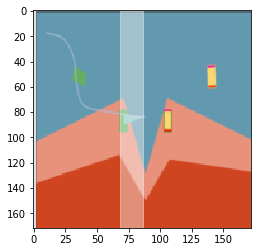

needle pose: tensor([4, 4, 4])


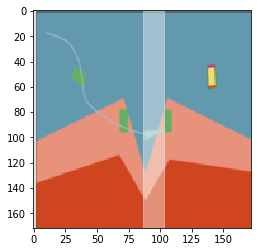

needle pose: tensor([5, 5, 4])


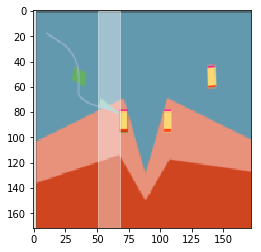

needle pose: tensor([3, 4, 5])


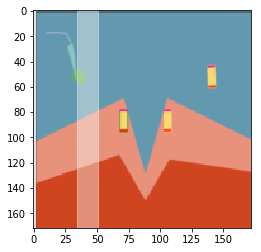

needle pose: tensor([2, 3, 6])


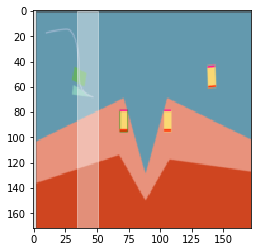

needle pose: tensor([2, 4, 5])


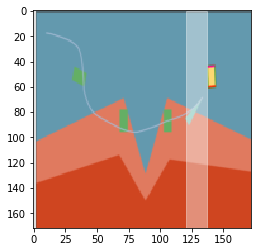

needle pose: tensor([7, 4, 3])


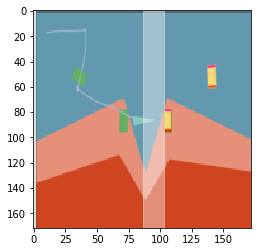

needle pose: tensor([5, 4, 4])


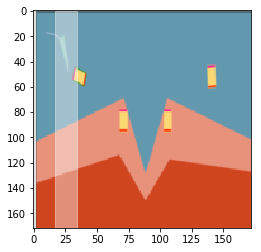

needle pose: tensor([1, 2, 6])


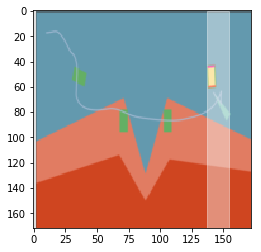

needle pose: tensor([7, 3, 1])


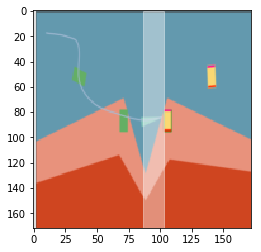

needle pose: tensor([5, 4, 4])


In [15]:
edge_size = 172
num_batches = 0

for dat in test_dataloader:
    
    num_batches = num_batches + 1
    outputs = model(dat['image'].to(DEVICE))
    prediction = outputs.cpu().detach().numpy()
    
    for idx in range(10):
        fig = plt.figure()
        torch_im = dat['image'][idx,:, :, :].permute(1,2,0).cpu().detach().numpy()
        im = np.multiply(torch_im, test_data_std) + test_data_mean
        plt.imshow(im)        
        
        if(MODE == 'regress'): # show where we predicted the needle to be 
            plt.scatter(dat['needle'][idx][0]*edge_size, dat['needle'][idx][1]*edge_size, c='r')
            plt.scatter(prediction[idx,0]*edge_size, prediction[idx,1]*edge_size, c='b')
                        
        elif(MODE == 'classify'):
            class_pred = np.argmax(prediction[idx,:])
            
            shape = patches.Polygon([[np.int(np.floor(class_pred/10.0 * edge_size)), 0], \
                            [np.int(np.floor((class_pred+1)/10.0 * edge_size)), 0], \
                            [np.int(np.floor((class_pred+1)/10.0 * edge_size)), edge_size], 
                            [np.int(np.floor(class_pred/10.0 * edge_size)), edge_size]], color='w', alpha=0.4)
            plt.gca().add_patch(shape)
            
            
        plt.show()
        
        print('needle pose: ' + str(dat['needle'][idx]))
    break

### Compute prediction error

In [16]:
edge_size = 172
num_batches = 0

euclidean_error = []
class_preds = []
true_labels = []
for dat in dataloader:
    
    num_batches = num_batches + 1
    outputs = model(dat['image'].to(DEVICE))
    prediction = outputs.cpu().detach().numpy()
    
    for idx in range(len(prediction)):
        if(MODE == 'regress'): # show where we predicted the needle to be 
            euc_err = np.linalg.norm(np.array([dat['needle'][idx][0]*edge_size, dat['needle'][idx][1]*edge_size]) - \
                                    np.array([prediction[idx,0]*edge_size, prediction[idx,1]*edge_size]))
            euclidean_error.append(euc_err)
            
        elif(MODE == 'classify'):
            class_pred = np.argmax(prediction[idx,:])
            class_preds.append(class_pred)
            true_labels.append(dat['needle'][idx][0])

In [17]:
np.mean(np.array(true_labels) == np.array(class_preds))

0.87117783419803507

In [18]:
true_labels

[tensor(1),
 tensor(4),
 tensor(2),
 tensor(1),
 tensor(8),
 tensor(2),
 tensor(2),
 tensor(3),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(4),
 tensor(3),
 tensor(2),
 tensor(1),
 tensor(5),
 tensor(6),
 tensor(3),
 tensor(3),
 tensor(1),
 tensor(7),
 tensor(2),
 tensor(3),
 tensor(7),
 tensor(5),
 tensor(4),
 tensor(7),
 tensor(2),
 tensor(6),
 tensor(4),
 tensor(1),
 tensor(4),
 tensor(2),
 tensor(2),
 tensor(6),
 tensor(3),
 tensor(1),
 tensor(5),
 tensor(1),
 tensor(1),
 tensor(2),
 tensor(1),
 tensor(3),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(5),
 tensor(5),
 tensor(2),
 tensor(4),
 tensor(4),
 tensor(3),
 tensor(2),
 tensor(7),
 tensor(4),
 tensor(7),
 tensor(4),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(5),
 tensor(2),
 tensor(2),
 tensor(4),
 tensor(5),
 tensor(2),
 tensor(4),
 tensor(2),
 tensor(5),
 tensor(4),
 tensor(5),
 tensor(2),
 tensor(6),
 tensor(5),
 tensor(4),
 tensor(2),
 tensor(4),
 tensor(6),
 tensor(6),
 tensor(7),
 tensor(2),
 tensor(2),
 ten

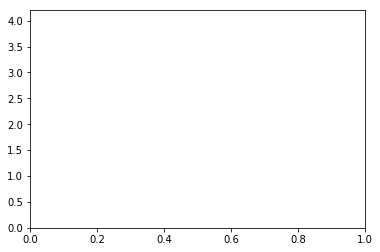

In [19]:
fig = plt.figure()
plt.hist(prediction[:,0])
plt.xlim([0,1])
plt.show()

# About this notebook
Created on 2/13/2019. Original code from surgical_activity_recognition.py by Mike Peven. Modified by Molly O'Brien. 

# Footer 